In [1]:
import os
from pathlib import Path
# import nfp
import numpy as np
import pandas as pd
import tarfile
from pymatgen.core import Structure
import json
import gzip
import re
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='notebook', 
        # font_scale=8/8.8,
        style='ticks',
        color_codes=True, 
        rc={'legend.frameon': False})

plt.rcParams['svg.fonttype'] = 'none'
# plt.rc('axes', labelsize=11)
# plt.rc('legend', fontsize=11)

%matplotlib inline

In [3]:
os.chdir("../")
os.getcwd()

'/lustre/eaglefs/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-pruning-outliers'

In [5]:
df_pred = pd.read_csv("/projects/rlmolecule/pstjohn/models/20220607_icsd_and_battery/predicted_energies.csv.gz",
                      index_col=0)
# df_pred.head()

In [6]:
df_pred['energy_err'] = (df_pred['energyperatom'] - df_pred['energy_predicted']).abs()
df_pred.groupby(['set', 'type']).energy_err.mean().unstack().round(3)

type,icsd,relax,vol
set,,,
test,0.058,0.035,0.060
test_composition,0.057,0.040,0.076
train,0.044,0.030,0.043
valid,0.059,0.034,0.067


In [32]:
df_pred['energy_err_real'] = df_pred['energy_predicted'] - df_pred['energyperatom']

In [34]:
test_data = df_pred[df_pred.set == "test"]
test_data.sort_values('type', ascending=False, inplace=True)
test_data.head(2)

/tmp/ipykernel_28408/145337972.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.sort_values('type', ascending=False, inplace=True)


,id,type,composition,num_sites,hit_upper_bound,energyperatom,volperatom,scaled_input_volperatom,set,energy_predicted,energy_err,energy_err_real
75048,Na1Hf1I2P1_sg2_icsd_171429_1,vol,Na1Hf1I2P1,20,False,-3.322296,32.974042,1.749668,test,-3.238382,0.083914,0.083914
42861,Na1Cd1I3_sg53_icsd_414116_2,vol,Na1Cd1I3,20,False,-1.108053,67.243879,2.188035,test,-1.104642,0.003411,0.003411


In [ ]:
out_dir = ""

In [24]:
# use the average from the learning curve
maes = {
    "icsd": 0.053,
    "relax": 0.032,
    "vol": 0.056,
}

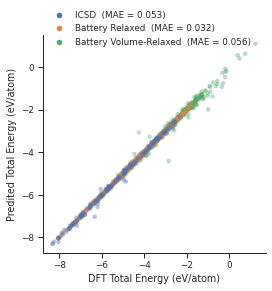

In [27]:
# f, ax = plt.subplots(figsize=(4,4))
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')
g = sns.scatterplot(data=test_data, x="energyperatom", y="energy_predicted", 
                hue="type", hue_order=["icsd", "relax", "vol"],
                alpha=.4, s=20, linewidth=0,
               )
g.legend_.set_title(None)
ax.legend(loc='upper left', bbox_to_anchor=(0, 1.15))
# replace labels
# new_labels = ['ICSD', 'Battery Relaxed', 'Battery Volume-Relaxed']
# for t, l in zip(g.legend_.texts, new_labels):
#     t.set_text(l)
new_labels = ['ICSD', 'Battery Relaxed', 'Battery Volume-Relaxed']
for t, l in zip(ax.legend_.texts, new_labels):
    data_type = t.get_text()
    # df = test_data[test_data.type == data_type]
    # mae = (df.energyperatom - df.energy_predicted).abs().mean()
    mae = maes[data_type]
    new_label = f"{l}  (MAE = {mae:0.2})"
    t.set_text(new_label)

# plt.xlim(-10, 5)
# plt.ylim(-10, 6)
plt.xlabel("DFT Total Energy (eV/atom)")
plt.ylabel("Predited Total Energy (eV/atom)")

# sns.despine(offset=5, trim=True)
sns.despine()

# plt.title("Training data: ICSD, Battery Relaxed")
plt.savefig(f"icsd-batt-vol-eval.svg", bbox_inches='tight')
# plt.savefig(f"icsd-batt-eval-vol.png", bbox_inches='tight', dpi=300)

In [28]:
test_data.head(2)

,id,type,composition,num_sites,hit_upper_bound,energyperatom,volperatom,scaled_input_volperatom,set,energy_predicted,energy_err
75048,Na1Hf1I2P1_sg2_icsd_171429_1,vol,Na1Hf1I2P1,20,False,-3.322296,32.974042,1.749668,test,-3.238382,0.083914
42861,Na1Cd1I3_sg53_icsd_414116_2,vol,Na1Cd1I3,20,False,-1.108053,67.243879,2.188035,test,-1.104642,0.003411


In [75]:
test_data2 = test_data[test_data.energy_err < .3]

/home/jlaw/.conda-envs/crystals_nfp0_3/lib/python3.8/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


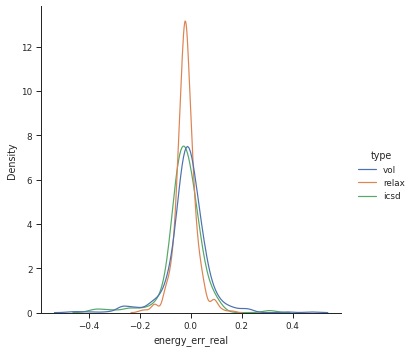

In [50]:
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')
sns.displot(data=test_data2, x='energy_err_real', ax=ax,
            # stat='percent',
            # stat="density", 
            common_norm=False,
            # kind="kde",
            hue='type')

In [95]:
sns.set_style('whitegrid')

In [91]:
plt.rcParams['text.usetex'] = False

In [108]:
# use the average from the learning curve
maes = {
    "icsd": 0.053 * 100,
    "relax": 0.032 * 100,
    "vol": 0.056 * 100,
}
labels = ["ICSD \nMAE = 53 meV/atom", 
          'Battery Relaxed \nMAE = 32 meV/atom', 
          'Battery Volume-Relaxed \nMAE = 56 meV/atom']


AxesSubplot(0.125,0.657941;0.775x0.222059) icsd
AxesSubplot(0.125,0.391471;0.775x0.222059) relax
AxesSubplot(0.125,0.125;0.775x0.222059) vol
/lustre/eaglefs/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-pruning-outliers/20220607_icsd_and_battery/icsd-batt-vol-eval.svg


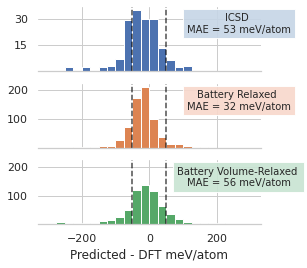

In [140]:
f, axes = plt.subplots(nrows=3, sharex=True, figsize=(4,4))
bins = np.arange(-.3, .31, .025) * 1000
colors = ["C0", "C1", "C2"]
# labels = ['ICSD', '
for ax, data_type, c in zip(axes, ['icsd', 'relax', 'vol'], colors):
    print(ax, data_type)
    curr_df = test_data2[test_data2.type == data_type]
    (curr_df.energy_err_real * 1000).plot.hist(bins=bins,
                                      color=c,
                                      ax=ax)
    
    ax.axvline(-50, linestyle='--', color='black', alpha=0.7)
    ax.axvline(50, linestyle='--', color='black', alpha=0.7)
    ax.set_ylabel("")
    
axes[2].set_ylim(axes[1].get_ylim())
axes[0].set_yticks([15, 30])
for ax in axes[1:]:
    ax.set_yticks([100, 200])

axes[2].set_xlabel("Predicted - DFT meV/atom")

# remove the borders
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
# also add text labels
background_colors = ["#c6d5e6", "#f8d8cb", "#c8e4d2"]
for ax, label, c in zip(axes, labels, background_colors):
    ax.text(.9, .6, label,
            # backgroundcolor=c,
            ha='center',
            bbox=dict(facecolor=c, alpha=0.9),
        # color='black',
       transform=ax.transAxes)

out_file = f"20220607_icsd_and_battery/icsd-batt-vol-eval.svg"
print(os.path.abspath(out_file))
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg', '.png'), bbox_inches='tight', dpi=300)

In [158]:
# use the average from the learning curve
labels = [f"ICSD \n N = {len(df_pred[df_pred.type == 'icsd'])}", 
          f"Battery Relaxed \n N = {len(df_pred[df_pred.type == 'relax'])}", 
          f"Battery Vol-Relaxed \n N = {len(df_pred[df_pred.type == 'vol'])}"]


AxesSubplot(0.125,0.657941;0.775x0.222059) icsd
AxesSubplot(0.125,0.391471;0.775x0.222059) relax
AxesSubplot(0.125,0.125;0.775x0.222059) vol
/lustre/eaglefs/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-pruning-outliers/20220607_icsd_and_battery/icsd-batt-vol-hist.svg


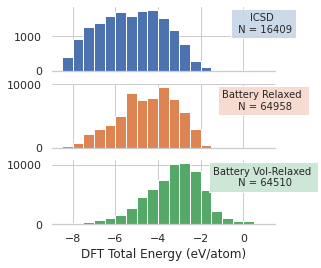

In [160]:
f, axes = plt.subplots(nrows=3, sharex=True, figsize=(4,4))
bins = np.arange(-8.5, 1.1, .5)
colors = ["C0", "C1", "C2"]
# labels = ['ICSD', '
for ax, data_type, c in zip(axes, ['icsd', 'relax', 'vol'], colors):
    print(ax, data_type)
    curr_df = df_pred[df_pred.type == data_type]
    (curr_df.energyperatom).plot.hist(bins=bins,
                                      color=c,
                                      ax=ax)
    
    # ax.axvline(-50, linestyle='--', color='black', alpha=0.7)
    # ax.axvline(50, linestyle='--', color='black', alpha=0.7)
    ax.set_ylabel("")
    
# axes[2].set_ylim(axes[1].get_ylim())
# axes[0].set_yticks([15, 30])
# for ax in axes[1:]:
#     ax.set_yticks([100, 200])

axes[2].set_xlabel("DFT Total Energy (eV/atom)")

# remove the borders
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
# also add text labels
background_colors = ["#c6d5e6", "#f8d8cb", "#c8e4d2"]
for ax, label, c in zip(axes, labels, background_colors):
    ax.text(.95, .6, label,
            # backgroundcolor=c,
            ha='center',
            bbox=dict(facecolor=c, alpha=0.9),
        # color='black',
       transform=ax.transAxes)

out_file = f"20220607_icsd_and_battery/icsd-batt-vol-hist.svg"
print(os.path.abspath(out_file))
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg', '.png'), bbox_inches='tight', dpi=300)

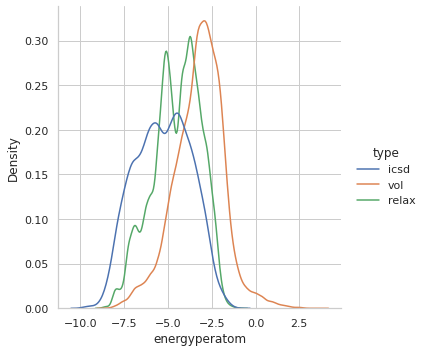

In [148]:
# fig = plt.figure(figsize=(4,4))
# ax = fig.add_subplot(111, aspect='equal', adjustable='datalim')
sns.displot(data=df_pred, x='energyperatom',
            # stat='percent',
            # stat="density", 
            common_norm=False,
            kind="kde",
            hue='type')

In [137]:
print(os.path.abspath(out_file))


/lustre/eaglefs/projects/rlmolecule/jlaw/projects/crystal-gnn-nfp-0.3-pruning-outliers/20220607_icsd_and_battery/icsd-batt-vol-eval.svg
